# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [253]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window
%matplotlib inline

In [254]:
# create a Spark session
# change this if it runs in a spark cluster
spark = SparkSession \
.builder \
.master('local') \
.appName('sparkify') \
.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [255]:
data_path = './mini_sparkify_event_data.json'
df = spark.read.json(data_path)

In [256]:
# check the schema of data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [257]:
# a glimpse of data
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [258]:
# convert registration and ts into timestamp
df = df.withColumn('registration_date', F.to_timestamp(df.registration/1000))
df = df.withColumn('log_date', F.to_timestamp(df.ts/1000))
df.select('registration_date', 'log_date').show(5)

+-------------------+-------------------+
|  registration_date|           log_date|
+-------------------+-------------------+
|2018-09-28 22:22:42|2018-10-01 00:01:57|
|2018-09-30 18:20:30|2018-10-01 00:03:00|
|2018-09-28 22:22:42|2018-10-01 00:06:34|
|2018-09-30 18:20:30|2018-10-01 00:06:56|
|2018-09-28 22:22:42|2018-10-01 00:11:16|
+-------------------+-------------------+
only showing top 5 rows



In [259]:
num_of_records = df.count()
num_of_no_userid = df.where("userId is null or userId == ''").count()
num_of_no_sessid = df.where("sessionId is null or sessionId == ''").count()
num_of_illegal_gender = df.where("gender <> 'M' and gender <> 'F'").count()
num_of_illegal_length = df.where('length <= 0').count()
max_registration_date = df.agg({'registration_date': 'max'}).collect()[0]['max(registration_date)']
min_registration_date = df.agg({'registration_date': 'min'}).collect()[0]['min(registration_date)']
max_log_date = df.agg({'log_date': 'max'}).collect()[0]['max(log_date)']
min_log_date = df.agg({'log_date': 'min'}).collect()[0]['min(log_date)']

print('number of records: {}'.format(num_of_records))
print('number of records with no user ID: {}'.format(num_of_no_userid))
print('number of records with no session ID: {}'.format(num_of_no_sessid))
print('number of records with illegal gender: {}'.format(num_of_illegal_gender))
print('number of records with length <= 0: {}'.format(num_of_illegal_length))
print('registration date range from {} to {}'.format(min_registration_date, max_registration_date))
print('log date range from {} to {}'.format(min_log_date, max_log_date))

number of records: 286500
number of records with no user ID: 8346
number of records with no session ID: 0
number of records with illegal gender: 0
number of records with length <= 0: 0
registration date range from 2018-03-18 13:44:35 to 2018-11-26 15:49:14
log date range from 2018-10-01 00:01:57 to 2018-12-03 01:11:16


In [260]:
# it seems that lengths have no abnormals
df_cleaned.describe(['length']).show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778349|
| stddev|99.23517921058327|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [261]:
# based on the checking above, records with no user ID will be cleaned
# these records are likely guests, we can simply ignore them
df_cleaned = df.where("userId is not null and userId <> ''")
df_cleaned.count()

278154

In [262]:
# location needs to split into address and area
split_loc = F.split(df_cleaned['location'], ',')
df_cleaned = df_cleaned.withColumn('address', split_loc.getItem(0))
df_cleaned = df_cleaned.withColumn('area', split_loc.getItem(1))
df_cleaned.select(['address', 'area']).show(5, False)

+-----------------------+------+
|address                |area  |
+-----------------------+------+
|Bakersfield            | CA   |
|Boston-Cambridge-Newton| MA-NH|
|Bakersfield            | CA   |
|Boston-Cambridge-Newton| MA-NH|
|Bakersfield            | CA   |
+-----------------------+------+
only showing top 5 rows



In [263]:
# extract month, day, weekday, weekend, hour from both registration date and log date
def extract_date_info(df, prefix, field):
    df = df.withColumn('{}_month'.format(prefix), F.date_format(field, 'M').cast(IntegerType()))
    df = df.withColumn('{}_day'.format(prefix), F.date_format(field, 'd').cast(IntegerType()))
    df = df.withColumn('{}_weekday'.format(prefix), F.date_format(field, 'u').cast(IntegerType()))
    df = df.withColumn('{}_hour'.format(prefix), F.date_format(field, 'H').cast(IntegerType()))
    extract_weekend = F.udf(lambda weekday: 1 if weekday == 6 or weekday == 7 else 0, IntegerType())
    df = df.withColumn('{}_weekend'.format(prefix), extract_weekend('{}_weekday'.format(prefix)))
    return df
    
df_cleaned = extract_date_info(df_cleaned, 'reg', 'registration_date')
df_cleaned = extract_date_info(df_cleaned, 'log', 'log_date')
# df_cleaned.select('reg_month', 'reg_day', 'reg_weekday', 'reg_hour', 'reg_weekend').show()
# df_cleaned.select('log_month', 'log_day', 'log_weekday', 'log_hour', 'log_weekend').show()

In [264]:
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- log_date: timestamp (nullable = true)
 |-- address: string (nullable = true)
 |-- area: string (nullable = true)
 |-- reg_month: integer (nullable = true)
 |-- reg_day: integer (nullable = true)
 |-- reg_weekday: integer (nullable = true)
 |-- reg_h

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [265]:
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- log_date: timestamp (nullable = true)
 |-- address: string (nullable = true)
 |-- area: string (nullable = true)
 |-- reg_month: integer (nullable = true)
 |-- reg_day: integer (nullable = true)
 |-- reg_weekday: integer (nullable = true)
 |-- reg_h

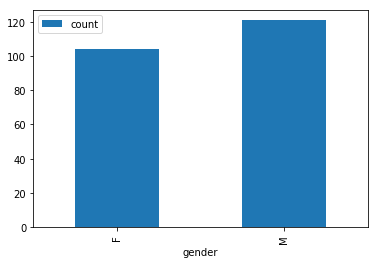

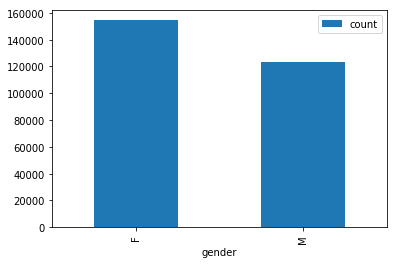

In [266]:
# there are more male audience than females, but females generates more records
gender_count = df_cleaned.dropDuplicates(['userId']).groupBy(df_cleaned.gender).count().toPandas()
gender_count = gender_count.set_index('gender')
gender_count.plot(kind='bar')

gender_listens = df_cleaned.groupBy(df_cleaned.gender).count().toPandas()
gender_listens = gender_listens.set_index('gender')
gender_listens.plot(kind='bar')

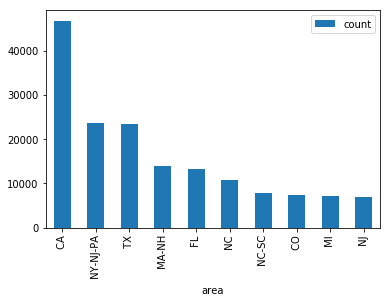

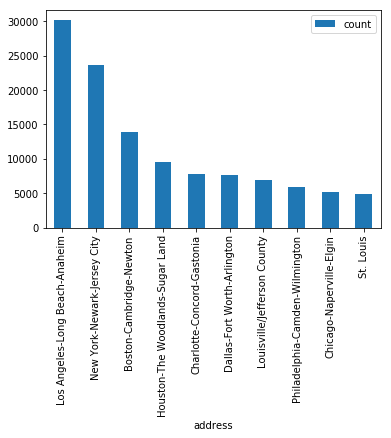

In [267]:
# which area is more active? California state outweighs a lot
area_count = df_cleaned.groupBy(df_cleaned.area).count().orderBy(F.desc('count')).limit(10).toPandas()
area_count = area_count.set_index('area')
area_count.plot(kind='bar')

# # which address is more active? Los Angeles-Long Beach-Anaheim and New York-Newark-Jersey City outweighs a lot
address_count = df_cleaned.groupBy(df_cleaned.address).count().orderBy(F.desc('count')).limit(10).toPandas()
address_count = address_count.set_index('address')
address_count.plot(kind='bar')

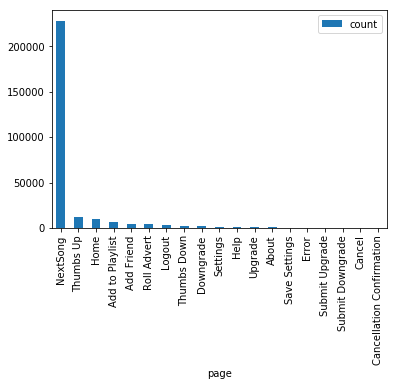

In [268]:
# page events statistics, 'downgrade' and 'cancellation confirmation' should be put focus on
page_count = df_cleaned.groupBy(df_cleaned.page).count().orderBy(desc('count')).toPandas()
page_count = page_count.set_index('page')
page_count.plot(kind='bar')

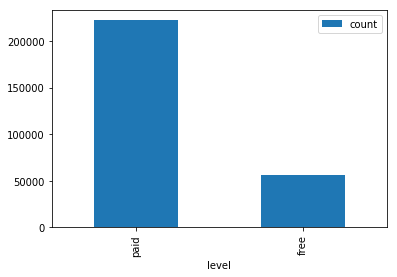

In [269]:
# paid and free users count, paid users outweighs free users
level_count = df_cleaned.groupBy(df_cleaned.level).count().orderBy(F.desc('count')).toPandas()
level_count = level_count.set_index('level')
level_count.plot(kind='bar')

In [270]:
related_events = ['Downgrade', 'Submit Downgrade', 'Cancellation Confirmation']
mark_churn_events = F.udf(lambda page: 1 if page in related_events else 0, IntegerType())
df_cleaned = df_cleaned.withColumn('churn', mark_churn_events('page'))

In [271]:
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- log_date: timestamp (nullable = true)
 |-- address: string (nullable = true)
 |-- area: string (nullable = true)
 |-- reg_month: integer (nullable = true)
 |-- reg_day: integer (nullable = true)
 |-- reg_weekday: integer (nullable = true)
 |-- reg_h

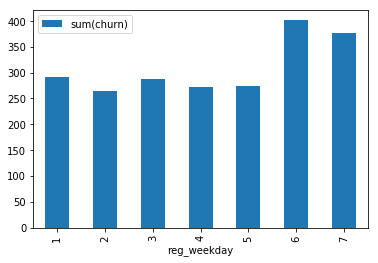

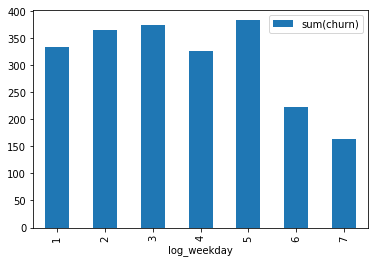

In [272]:
# users registered in weekend tends to do more churns
reg_weekday_churn = df_cleaned.groupBy(df_cleaned.reg_weekday).sum('churn').orderBy('reg_weekday').toPandas()
reg_weekday_churn = reg_weekday_churn.set_index('reg_weekday')
reg_weekday_churn.plot(kind='bar')

# but users tend to do less churns at weekend
log_weekday_churn = df_cleaned.groupBy(df_cleaned.log_weekday).sum('churn').orderBy('log_weekday').toPandas()
log_weekday_churn = log_weekday_churn.set_index('log_weekday')
log_weekday_churn.plot(kind='bar')

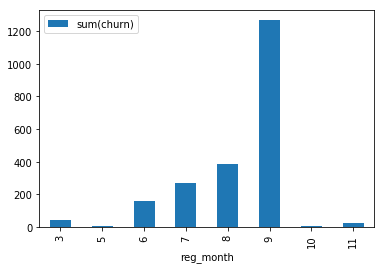

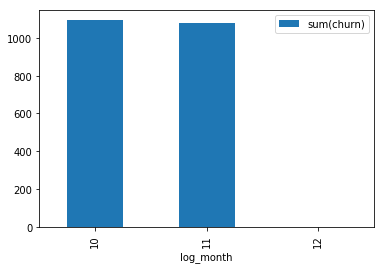

In [273]:
# users registered in September more likely to churn
reg_month_churn = df_cleaned.groupBy('reg_month').sum('churn').orderBy('reg_month').toPandas()
reg_month_churn = reg_month_churn.set_index('reg_month')
reg_month_churn.plot(kind='bar')

# users tends to do no churn in December
log_month_churn = df_cleaned.groupBy('log_month').sum('churn').orderBy('log_month').toPandas()
log_month_churn = log_month_churn.set_index('log_month')
log_month_churn.plot(kind='bar')

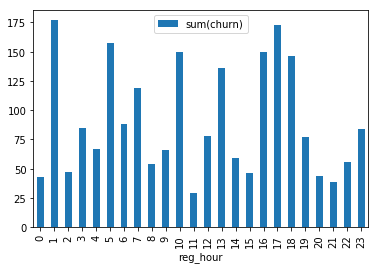

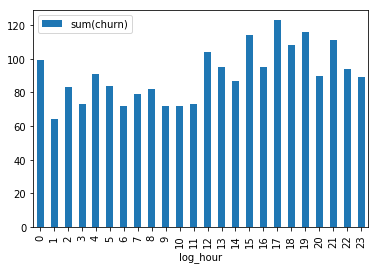

In [274]:
# thers' no obvious relation between registration hour and churn
reg_hour_churn = df_cleaned.groupBy(df_cleaned.reg_hour).sum('churn').orderBy('reg_hour').toPandas()
reg_hour_churn = reg_hour_churn.set_index('reg_hour')
reg_hour_churn.plot(kind='bar')

# users tend to churn from 12 p.m to 0 a.m
log_hour_churn = df_cleaned.groupBy(df_cleaned.log_hour).sum('churn').orderBy('log_hour').toPandas()
log_hour_churn = log_hour_churn.set_index('log_hour')
log_hour_churn.plot(kind='bar')

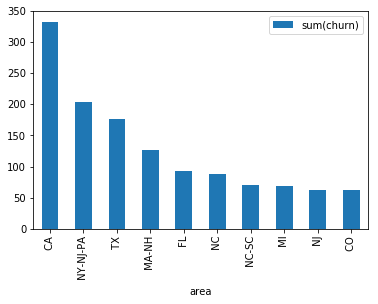

In [275]:
# some areas are more likely to churn 
area_churn = df_cleaned.groupBy(df_cleaned.area).sum('churn').orderBy(F.desc('sum(churn)')).limit(10).toPandas()
area_churn = area_churn.set_index('area')
area_churn.plot(kind='bar')

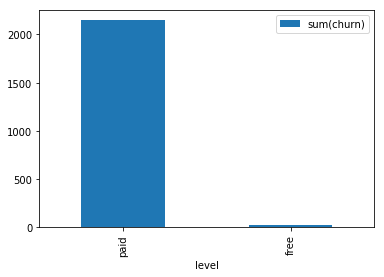

In [276]:
# of course paid users are likely to churn
level_churn = df_cleaned.groupBy(df_cleaned.level).sum('churn').orderBy(F.desc('sum(churn)')).toPandas()
level_churn = level_churn.set_index('level')
level_churn.plot(kind='bar')

In [277]:
# if page == 'Home' mark 1
mark_home = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())

# window for accumulate sum of homevisit field
user_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

# mark every home visit interval as a 'period'
cusum = df_cleaned.filter((df_cleaned.page == 'NextSong') | (df_cleaned.page == 'Home')) \
    .select('userId', 'page', 'ts') \
    .withColumn('homevisit', mark_home('page')) \
    .withColumn('period', F.sum('homevisit').over(user_window))

# calculate average songs listened between periods
avg_songs_between_home = cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}).groupBy('userId').avg('count(period)')

# join back to df_cleaned
df_cleaned = df_cleaned.join(avg_songs_between_home, 'userId').withColumnRenamed('avg(count(period))', 'avg_songs')
# df_cleaned.show()


+-----+-----------------+
|churn|   sum(avg_songs)|
+-----+-----------------+
|    1|53151.92663357414|
|    0|6690845.435682899|
+-----+-----------------+



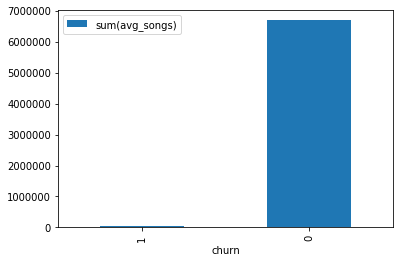

In [279]:
# users who churned tend to listen much less songs than others
avg_songs_churn = df_cleaned.groupBy(df_cleaned.churn).sum('avg_songs').toPandas()
avg_songs_churn = avg_songs_churn.set_index('churn')
avg_songs_churn.plot(kind='bar')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.